In [1]:
# Avoid interference with GDAL from other external software due to environment variables used: GDAL_DATA and PROJ_LIB

import os
import getpass

usuario = getpass.getuser()

# os.environ['GDAL_DATA'] = f'/opt/anaconda3/envs/geoenv/share/gdal'
# os.environ['PROJ_LIB'] = f'/opt/anaconda3/envs/geoenv/share'

# en windows, NECESARIO EN AULA y seguramente en equipos con la misma instalación y SO
os.environ['GDAL_DATA'] = f'C:\\Users\\{usuario}\\anaconda3\\envs\\advprog\\Library\\share\\gdal'
os.environ['PROJ_LIB'] = f'C:\\Users\\{usuario}\\anaconda3\\envs\\advprog\\Library\\share\\proj'
os.environ['PATH'] = f'C:\\Users\\{usuario}\\anaconda3\\envs\\advprog\\Library\\bin'

In [19]:
import pandas as pd
import geopandas as gpd
import numpy as np
import xarray
import shapely
import sys
import os
import matplotlib.pyplot as plt
from shapely.geometry import Point
from pyproj import CRS
import contextily as ctx
from ipywidgets import interact, fixed
from pointpats import distance_statistics
from sklearn.cluster import DBSCAN
import seaborn as sns

In [3]:
sys.argv[1] = "C:\\Users\\angel\\Documents\\Programacion_avanzada\\practicas\\Geodatos\\"

In [4]:
eucal_cant = gpd.read_file(sys.argv[1] + "eucal_cant.shp")
cantabria = gpd.read_file(sys.argv[1] + "shp_cantabria\\cantabria.shp")
euc_mfe_cant = gpd.read_file(sys.argv[1] + "Eucaliptales_Cornisa_Cantabrica\\Eucaliptales_Cornisa_Cantabrica.shp")

In [5]:
cantabria = cantabria.to_crs(eucal_cant.crs)
euc_mfe_cant = euc_mfe_cant[euc_mfe_cant["NUT3_NOM"] == "Cantabria"]

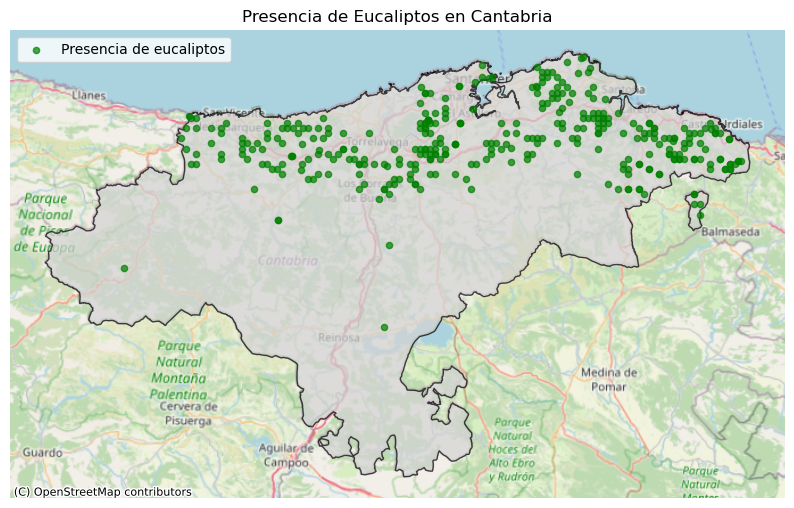

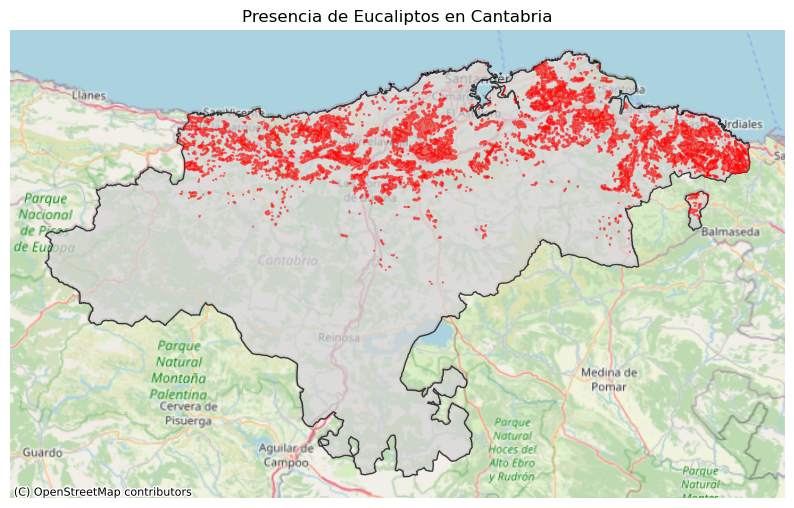

In [6]:
# Crear la figura
fig, ax = plt.subplots(figsize=(10, 10))

# Dibujar límites de Cantabria
cantabria.plot(ax=ax, edgecolor='black', color='lightgray', alpha=0.7)

# Dibujar puntos de presencia de eucaliptos
eucal_cant.plot(ax=ax, marker='o', color='green', markersize=20, alpha=0.7, label='Presencia de eucaliptos')

# Añadir fondo de mapa
ctx.add_basemap(ax, crs=cantabria.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Mejorar el diseño
plt.title("Presencia de Eucaliptos en Cantabria")
plt.legend()

# Quitar ejes
ax.set_axis_off()

# Mostrar el mapa
plt.show()

# Crear la figura
fig, ax = plt.subplots(figsize=(10, 10))

# Dibujar límites de Cantabria
cantabria.plot(ax=ax, edgecolor='black', color='lightgray', alpha=0.7)

# Dibujar polígonos de eucaliptos
euc_mfe_cant.plot(ax=ax, edgecolor='red', color='red', alpha=0.5, label='Zonas de eucaliptos')

# Añadir fondo de mapa
ctx.add_basemap(ax, crs=cantabria.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Mejorar el diseño
plt.title("Presencia de Eucaliptos en Cantabria")

# Quitar ejes
ax.set_axis_off()

# Mostrar el mapa
plt.show()


In [7]:
municipios = gpd.read_file(sys.argv[1] + "Municipios\\Municipios_IGN.shp")
municipios = municipios.to_crs(eucal_cant.crs)
municipios.crs

C:\Users\angel\anaconda3\envs\advprog\lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: C:\Users\angel\Documents\Programacion_avanzada\practicas\Geodatos\Municipios\Municipios_IGN.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


<Projected CRS: EPSG:25830>
Name: ETRS89 / UTM zone 30N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 6°W and 0°W: Faroe Islands offshore; Ireland - offshore; Jan Mayen - offshore; Norway including Svalbard - offshore; Spain - mainland - onshore and offshore.
- bounds: (-6.0, 35.26, 0.01, 80.49)
Coordinate Operation:
- name: UTM zone 30N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [8]:
municipios_cantabria = gpd.overlay(municipios, cantabria, how='intersection')


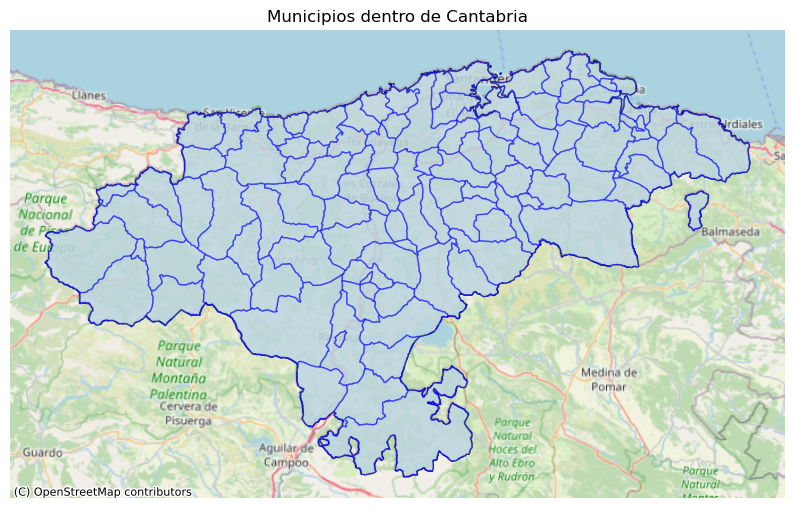

In [9]:
# Mostrar el resultado
fig, ax = plt.subplots(figsize=(10, 10))

# Dibujar límites de Cantabria
cantabria.plot(ax=ax, edgecolor='black', color='lightgray', alpha=0.7)

# Dibujar municipios dentro de Cantabria
municipios_cantabria.plot(ax=ax, edgecolor='blue', color='lightblue', alpha=0.5, label="Municipios en Cantabria")

# Añadir fondo de mapa
import contextily as ctx
ctx.add_basemap(ax, crs=cantabria.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Mejorar diseño
plt.title("Municipios dentro de Cantabria")
ax.set_axis_off()

plt.show()

C:\Users\angel\AppData\Local\Temp\ipykernel_23592\2610578329.py:14: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  municipios_eucaliptos.to_file(sys.argv[1] + "Municipios\\Municipios_Eucaliptos.shp")
C:\Users\angel\anaconda3\envs\advprog\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'INSPIREID_1' to 'INSPIREID_'
  ogr_write(
C:\Users\angel\anaconda3\envs\advprog\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'INSPIREID_2' to 'INSPIREI_1'
  ogr_write(


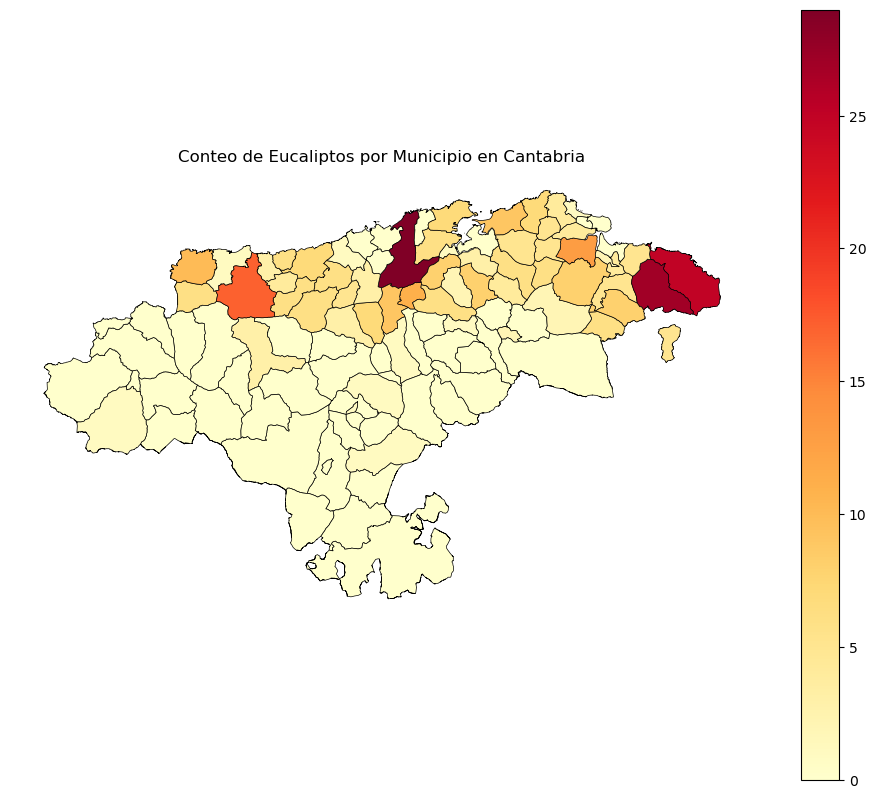

In [10]:
# Hacer una unión espacial para asignar cada punto a su municipio
joined = gpd.sjoin(eucal_cant, municipios_cantabria, how="inner", predicate="within")

# Contar el número de puntos por municipio
conteo = joined.groupby("index_right").size().reset_index(name="euc_count")

# Añadir el conteo a la tabla de municipios
municipios_eucaliptos = municipios_cantabria.join(conteo.set_index("index_right"))

# Rellenar con 0 los municipios sin eucaliptos (si es necesario)
municipios_eucaliptos["euc_count"] = municipios_eucaliptos["euc_count"].fillna(0).astype(int)

# Guardar el resultado en un nuevo shapefile
municipios_eucaliptos.to_file(sys.argv[1] + "Municipios\\Municipios_Eucaliptos.shp")

# Mostrar el resultado
fig, ax = plt.subplots(figsize=(12, 10))

# Dibujar municipios coloreando por el número de eucaliptos
municipios_eucaliptos.plot(
    column="euc_count",
    cmap="YlOrRd",
    edgecolor="black",
    linewidth=0.5,
    legend=True,
    ax=ax
)

# Añadir título y mejorar diseño
plt.title("Conteo de Eucaliptos por Municipio en Cantabria")
ax.set_axis_off()

plt.show()


In [11]:
eucal_cant

,genus,species,decimalLat,decimalLon,elevation,geometry
0,Eucalyptus,Eucalyptus globulus,43.118865,-4.661279,NaN,POINT (364851.922 4775354.135)
1,Eucalyptus,Eucalyptus globulus,43.208872,-4.291274,NaN,POINT (395107.05 4784819.375)
2,Eucalyptus,Eucalyptus globulus,43.208872,-4.291274,NaN,POINT (395107.05 4784819.375)
3,Eucalyptus,Eucalyptus globulus,43.262917,-4.350480,420.98,POINT (390394.463 4790897.316)
4,Eucalyptus,Eucalyptus globulus,43.290900,-4.281900,NaN,POINT (396008.177 4793917.334)
...,...,...,...,...,...,...
350,Eucalyptus,Eucalyptus globulus,43.484901,-3.539052,NaN,POINT (456409.81 4814805.63)
351,Eucalyptus,Eucalyptus globulus,43.485200,-3.667800,NaN,POINT (445998.906 4814914.295)
352,Eucalyptus,Eucalyptus globulus,43.494600,-3.593700,NaN,POINT (451998.399 4815912.846)
353,Eucalyptus,Eucalyptus globulus,43.501545,-3.561550,103.47,POINT (454602.986 4816666.108)


### $G$ de Ripley

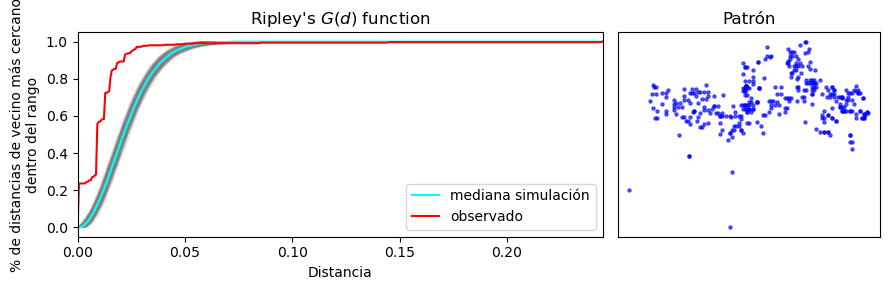

In [12]:
# Asegurar que no hay datos nulos
eucal_cant = eucal_cant.dropna(subset=["decimalLon", "decimalLat"])

# Extraer las coordenadas
coordinates = eucal_cant[["decimalLon", "decimalLat"]].values

# Test de Ripley
g_test = distance_statistics.g_test(
    coordinates, support=400, keep_simulations=True, n_simulations=999
)

# Crear figura y ejes
f, ax = plt.subplots(1, 2, figsize=(9, 3), gridspec_kw=dict(width_ratios=(6, 3)))

# Graficar todas las simulaciones
ax[0].plot(g_test.support, g_test.simulations.T, color='gray', alpha=0.05, lw=0.5)

# Mostrar la mediana de las simulaciones
ax[0].plot(g_test.support, np.median(g_test.simulations, axis=0), color='cyan', label='mediana simulación')

# Mostrar el valor observado
ax[0].plot(g_test.support, g_test.statistic, label='observado', color='red')

# Mejorar diseño de ejes y leyenda
ax[0].set_xlabel('Distancia')
ax[0].set_ylabel('% de distancias de vecino más cercano\ndentro del rango')
ax[0].legend()
ax[0].set_xlim(min(g_test.support), max(g_test.support))
ax[0].set_title(r"Ripley's $G(d)$ function")

# Mostrar el patrón en el otro eje
ax[1].scatter(*coordinates.T, s=5, color="blue", alpha=0.6)

# Limpiar etiquetas y ejes
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title('Patrón')

# Ajustar diseño
f.tight_layout()

# Mostrar
plt.show()


Dado que el patrón observado incrementa mucho más rápido que el de la simulación, esto indica que los puntos de eucaliptos están más cercas entre ellos de lo esperado. Por lo tanto, se puede establecer su agrupación.

### $F$ de Ripley

In [13]:
f_test = distance_statistics.f_test(
    coordinates, support=400, keep_simulations=True, n_simulations=999
)

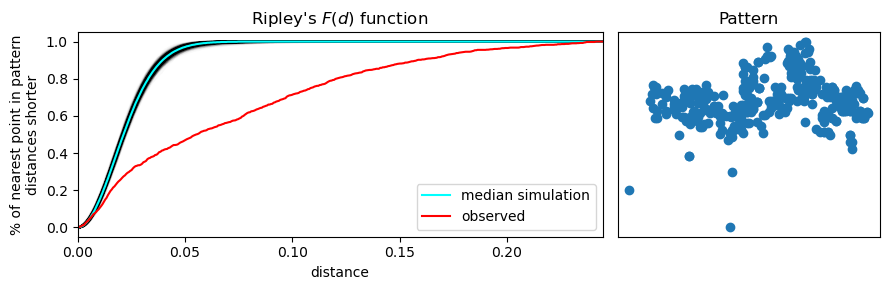

In [14]:
f,ax = plt.subplots(
    1,2,figsize=(9,3), gridspec_kw=dict(width_ratios=(6,3))
)

# plot all the simulations with very fine lines
ax[0].plot(f_test.support, f_test.simulations.T, color='k', alpha=.01)

# and show the average of simulations
ax[0].plot(f_test.support, np.median(f_test.simulations, axis=0), color='cyan', 
         label='median simulation')


# and the observed pattern's F function
ax[0].plot(f_test.support, f_test.statistic, label = 'observed', color='red')

# clean up labels and axes
ax[0].set_xlabel('distance')
ax[0].set_ylabel('% of nearest point in pattern\ndistances shorter')
ax[0].legend()
ax[0].set_xlim(min(f_test.support), max(f_test.support))
ax[0].set_title(r"Ripley's $F(d)$ function")

# plot the pattern itself on the next frame
ax[1].scatter(*coordinates.T)

# and clean up labels and axes there, too
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].set_title('Pattern')
f.tight_layout()
plt.show()

Podemos ver cómo la función aumenta de manera más lenta que la simulación. Esto demuestra que hay mayores espacios vacíos que los que habría en una simulación aleatoria, ya que muestra la distancia desde puntos vacíos hasta los puntos observados

In [15]:
coordinates = np.array(list(zip(eucal_cant.geometry.x, eucal_cant.geometry.y)))

In [16]:
algorit = DBSCAN(eps=2000, min_samples=4)
eucal_cant['cluster'] = algorit.fit_predict(coordinates)

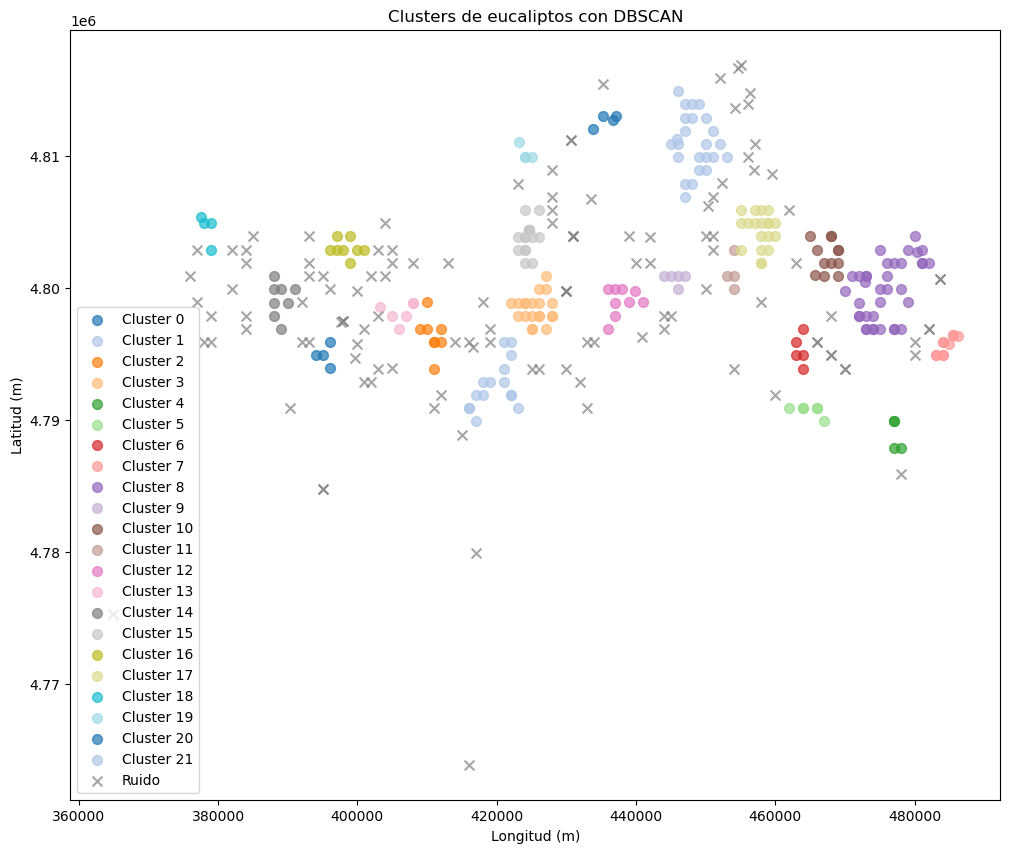

In [17]:
fig, ax = plt.subplots(figsize=(12, 10))
for cluster in set(eucal_cant['cluster']):
    subset = eucal_cant[eucal_cant['cluster'] == cluster]
    if cluster == -1:
        color = 'gray'
        label = 'Ruido'
        marker = 'x'
    else:
        color = plt.cm.tab20(cluster % 20)
        label = f'Cluster {cluster}'
        marker = 'o'
        
    ax.scatter(subset.geometry.x, subset.geometry.y, 
               s=50, color=color, label=label, marker=marker, alpha=0.7)

# ✅ Mejorar el diseño
plt.title("Clusters de eucaliptos con DBSCAN")
plt.xlabel("Longitud (m)")
plt.ylabel("Latitud (m)")

# ✅ Leyenda sin duplicados
handles, labels = ax.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
ax.legend(unique_labels.values(), unique_labels.keys(), loc="best")

plt.show()


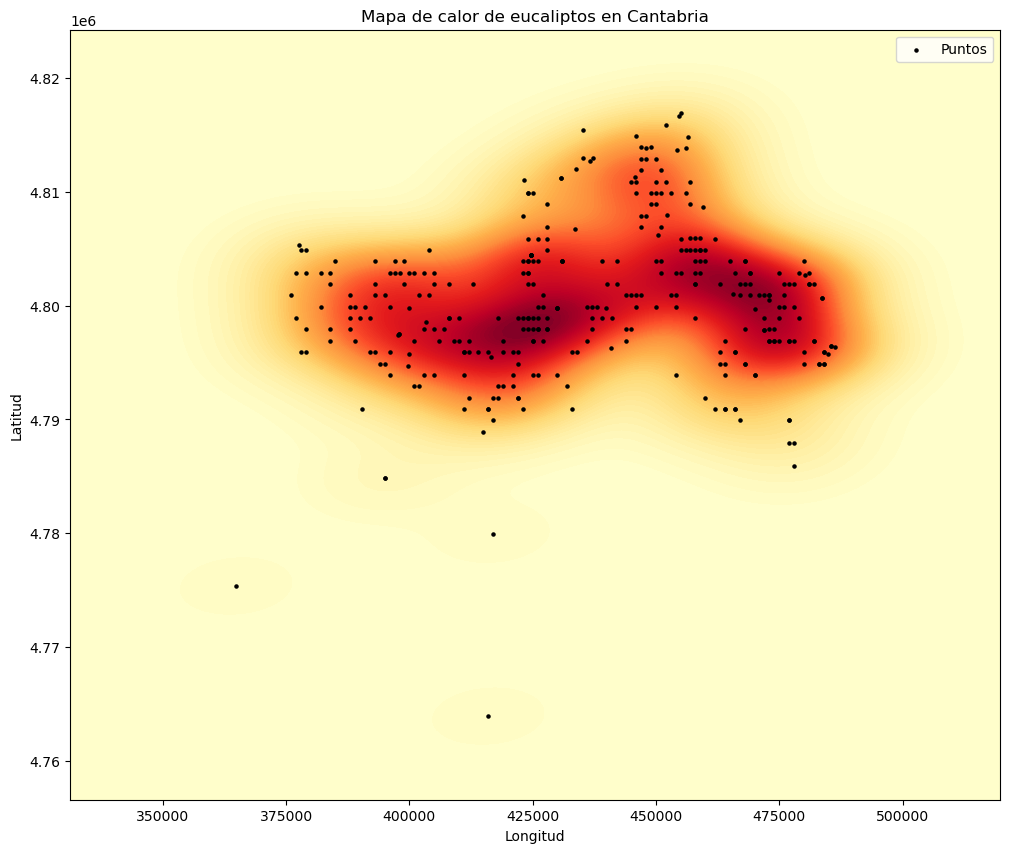

In [20]:

plt.figure(figsize=(12, 10))
sns.kdeplot(
    x=coordinates[:, 0],
    y=coordinates[:, 1],
    cmap="YlOrRd",  # Colores tipo calor
    fill=True,
    thresh=0,
    levels=100
)
plt.scatter(coordinates[:, 0], coordinates[:, 1], s=5, color="black", label="Puntos")

plt.title('Mapa de calor de eucaliptos en Cantabria')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.legend()
plt.show()
